In [1]:
%load_ext autoreload
%autoreload 2

import compression as C
import backports.lzma as lzma
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

%matplotlib inline

ac3 = C.Util.load_data('ac3', -1, '/Volumes/FFRITZ/cs222/ac3/rhoana/')

# maybe this can be tuned
LZMA_filters = [{"id": lzma.FILTER_LZMA1, "preset": lzma.PRESET_EXTREME}]

/Users/Fritz/Virtualenvs/cs222/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<function matplotlib.pyplot.show>

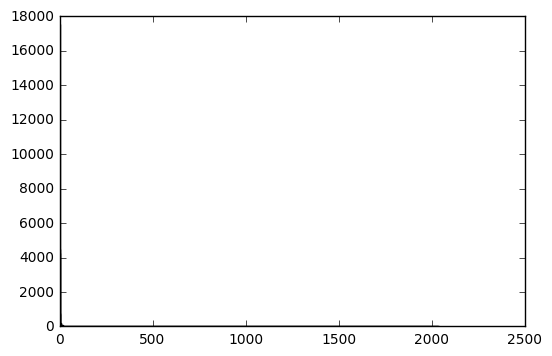

In [2]:
# Show distribution of x and y

bac3 = C.B2D.encode(ac3[0])

x = bac3[(4 + int(bac3[2] * 2)) : int(-1 * bac3[3])]
y = bac3[int(-1 * bac3[3]):]
plt.hist(x, bins=range(min(x), max(x)))
plt.show

plt.hist(y, bins=range(min(y), max(y)))
plt.show

In [3]:
# Compare different border encoding settings

for i in range(4):
    s_ac3 = C.Util.get_size(ac3[i])
    s_rle = C.Util.get_size(C.RLE.encode(ac3[i]))
    s_lzma_rle = C.Util.get_size(C.LZMA.compress(C.RLE.encode(ac3[i])))
    s_b = C.Util.get_size(C.B2D.encode(ac3[i]))
    s_lzma_b = C.Util.get_size(C.LZMA.compress(C.B2D.encode(ac3[i])))
    s_lzmax_b = C.Util.get_size(C.LZMA.compress(C.B2D.encode(ac3[i], zz=False), format=lzma.FORMAT_RAW, filters=LZMA_filters))
    s_lzmax_zz_b = C.Util.get_size(C.LZMA.compress(C.B2D.encode(ac3[i]), format=lzma.FORMAT_RAW, filters=LZMA_filters))

    print i, '|', s_ac3, s_rle, s_b, s_lzma_rle, s_lzma_b, s_lzmax_b, s_lzmax_zz_b
    print i, '|', 1, s_ac3 / s_rle, s_ac3 / s_b, s_ac3 / s_lzma_rle, s_ac3 / s_lzma_b, s_ac3 / s_lzmax_b, s_ac3 / s_lzmax_zz_b

0 | 8388608 328904 318704 15376 14100 13312 13184
0 | 1 25 26 545 594 630 636
1 | 8388608 322488 312080 15124 13772 13055 12944
1 | 1 26 26 554 609 642 648
2 | 8388608 320072 309456 14828 13660 12883 12811
2 | 1 26 27 565 614 651 654
3 | 8388608 319064 308576 14844 13704 12956 12808
3 | 1 26 27 565 612 647 654


In [60]:
# Test zigzag encoding of vector to avoid negative numbers

for i in range(4):
    b_ac3 = C.B2D.encode(ac3[i])

    x = bac3[(4 + int(b_ac3[2] * 2)) : int(-1 * b_ac3[3])]
    y = bac3[int(-1 * b_ac3[3]):]

    zz_x = C.zigzag.encode(x)
    zz_y = C.zigzag.encode(y)

    s_x = C.Util.get_size(C.LZMA.compress(x))
    s_y = C.Util.get_size(C.LZMA.compress(y))
    s_zz_x = C.Util.get_size(C.LZMA.compress(zz_x))
    s_zz_y = C.Util.get_size(C.LZMA.compress(zz_y))

    print s_x, s_zz_x, s_y, s_zz_y

10064 9772 3068 3104
10192 9904 2988 3016
10224 9948 2984 3016
10200 9928 2984 3012


In [73]:
# Test various compression on different parts of the encoded data
b_ac3 = C.B2D.encode(ac3[0])

header = b_ac3[0:4]
keys = b_ac3[4:4 + int(b_ac3[2])]
starts = b_ac3[4 + int(b_ac3[2]):4 + int(b_ac3[2] * 2)]
x = bac3[(4 + int(b_ac3[2] * 2)) : int(-1 * b_ac3[3])]
y = bac3[int(-1 * b_ac3[3]):]

assert len(b_ac3) == len(header) + len(keys) + len(starts) + len(x) + len(y)

print 'MAXs', max(header), max(keys), max(starts), max(x), max(y)

s_lzmax_zz_b = C.Util.get_size(C.LZMA.compress(b_ac3, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_lzmax_16_zz_b = C.Util.get_size(C.LZMA.compress(b_ac3.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))

print s_lzmax_zz_b, s_lzmax_16_zz_b

# Test bit separation
ui8, ui16, ui32, ui64 = C.Extract.encode(x)
print 'X:', len(ui8), len(ui16)


s_x_all = C.Util.get_size(C.LZMA.compress(x.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_x_ui8 = C.Util.get_size(C.LZMA.compress(ui8, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_x_ui16 = C.Util.get_size(C.LZMA.compress(ui16, format=lzma.FORMAT_RAW, filters=LZMA_filters))

print 'X:', s_x_all, s_x_ui8, s_x_ui16

ui8, ui16, ui32, ui64 = C.Extract.encode(y)
print 'Y:', len(ui8), len(ui16)


s_y_all = C.Util.get_size(C.LZMA.compress(y.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_y_ui8 = C.Util.get_size(C.LZMA.compress(ui8, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_y_ui16 = C.Util.get_size(C.LZMA.compress(ui16, format=lzma.FORMAT_RAW, filters=LZMA_filters))

print 'Y:', s_y_all, s_y_ui8, s_y_ui16

MAXs 19531 6178 727 1020 1018
13184 12168
X: 19531 292
X: 9308 7696 515
Y: 19531 345
Y: 2282 1599 322


In [17]:
# Test RLE on x and y
b_ac3 = C.B2D.encode(ac3[0])

header = b_ac3[0:4]
keys = b_ac3[4:4 + int(b_ac3[2])]
starts = b_ac3[4 + int(b_ac3[2]):4 + int(b_ac3[2] * 2)]
x = b_ac3[(4 + int(b_ac3[2] * 2)) : int(-1 * b_ac3[3])]
y = b_ac3[int(-1 * b_ac3[3]):]


s_x = C.Util.get_size(C.LZMA.compress(x.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_y = C.Util.get_size(C.LZMA.compress(y.astype(np.uint16), format=lzma.FORMAT_RAW, filters=LZMA_filters))

s_rle_x = C.Util.get_size(C.LZMA.compress(C.RLE.encode(x.astype(np.uint16)), format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_rle_y = C.Util.get_size(C.LZMA.compress(C.RLE.encode(y.astype(np.uint16)), format=lzma.FORMAT_RAW, filters=LZMA_filters))

print s_x, s_rle_x, s_y, s_rle_y

8865 9740 2315 2515


In [74]:
# Test Bit Splitter
b_ac3 = C.B2D.encode(ac3[0])
ui8, ui16, ui32, ui64 = C.Extract.encode(b_ac3)

s_ac3_all = C.Util.get_size(C.LZMA.compress(b_ac3, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_ac3_ui8 = C.Util.get_size(C.LZMA.compress(ui8, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_ac3_ui16 = C.Util.get_size(C.LZMA.compress(ui16, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_ac3_ui32 = C.Util.get_size(C.LZMA.compress(ui32, format=lzma.FORMAT_RAW, filters=LZMA_filters))
s_ac3_ui64 = C.Util.get_size(C.LZMA.compress(ui64, format=lzma.FORMAT_RAW, filters=LZMA_filters))

print 'AC3[0]:', s_ac3_all, s_ac3_ui8 + s_ac3_ui16 + s_ac3_ui32 + s_ac3_ui64

AC3[0]: 13184 11503


In [20]:
# Sanity check for 1D, 2D, and 3D RLE

assert np.array_equal(ac3[0, 0], C.RLE.decode(C.RLE.encode(ac3[0, 0])))
assert np.array_equal(ac3[0], C.RLE.decode(C.RLE.encode(ac3[0])))
assert np.array_equal(ac3[0:1], C.RLE.decode(C.RLE.encode(ac3[0:1])))

largest_p 63 <type 'numpy.uint64'>
0 17870283321406128128 72691


<function matplotlib.pyplot.show>

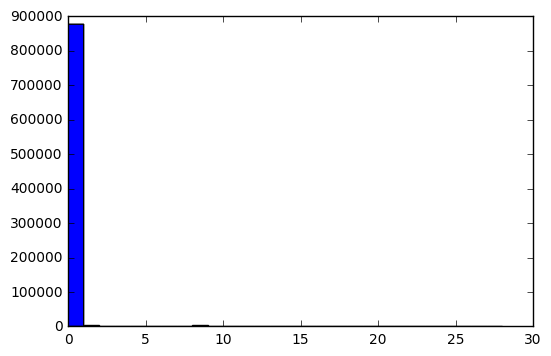

In [20]:
# Border distribution
b_rle = C.B2D.get_borders_stack(ac3, window_size=[16, 4])
borders = np.fromstring(b_rle[10:], dtype=np.uint64)

print min(borders), max(borders), np.unique(borders).shape[0]

In [ ]:
# Print the distribution
plt.hist(borders, bins=range(0, 2^32 - 1))
plt.show

In [16]:
C.Util.get_size(C.LZMA.compress(C.B2D.get_borders_stack(ac3, window_size=[16,4])))

compression/b2d.py:99: RuntimeWarning: overflow encountered in long_scalars
  borders[i] = num


largest_p 63 <type 'numpy.uint64'>


752972

In [4]:
C.Util.get_size(C.RLE_MATEJEK.compress(ac3))

------------------------
Compression Results: 
  Matejek: 889752
    IDs: 30648
        3.44455533677
    Values: 134844
        15.1552342675
    Boundaries: 700480
        78.7275555436
    Locations: 23708
        2.66456270961
    Ratio: 707.10220376
  RLE: 1044652
    Ratio: 602.25376489
------------------------


889752

In [11]:
# Test different window sizes
for i in range(0, ac3.shape[0], 5):
    print '%d: 32x2:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[32,2])))
    print '%d: 16x4:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[16,4])))
    print '%d: 4x16:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[4,16])))
    print '%d: 8x8:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[8,8])))
    print '%d: 8x4:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[8,4])))
    print '%d: 4x8:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[4,8])))
    print '%d: 4x4:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[4,4])))
    print '%d: 4x2:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[4,2])))
    print '%d: 2x4:' % i, C.Util.get_size(C.LZMA.compress(C.B2D.get_borders(ac3[i], window_size=[2,4])))
    print '---'

 0: 32x2: 12340
0: 16x4: 11764
0: 4x16: 13932
0: 8x8: 12428
0: 8x4: 11932
0: 4x8: 13044
0: 4x4: 12692
0: 4x2: 12316
0: 2x4: 14832
---
5: 32x2: 11840
5: 16x4: 11396
5: 4x16: 13264
5: 8x8: 11980
5: 8x4: 11580
5: 4x8: 12528
5: 4x4: 12176
5: 4x2: 11868
5: 2x4: 14108
---
10: 32x2: 12420
10: 16x4: 11892
10: 4x16: 14000
10: 8x8: 12496
10: 8x4: 12052
10: 4x8: 13160
10: 4x4: 12808
10: 4x2: 12444
10: 2x4: 14876
---
15: 32x2: 12584
15: 16x4: 11980
15: 4x16: 14280
15: 8x8: 12704
15: 8x4: 12216
15: 4x8: 13412
15: 4x4: 13116
15: 4x2: 12720
15: 2x4: 15164
---
20: 32x2: 12580
20: 16x4: 12080
20: 4x16: 14156
20: 8x8: 12716
20: 8x4: 12248
20: 4x8: 13304
20: 4x4: 13012
20: 4x2: 12632
20: 2x4: 15292
---
25: 32x2: 11752
25: 16x4: 11244
25: 4x16: 13396
25: 8x8: 11964
25: 8x4: 11512
25: 4x8: 12616
25: 4x4: 12292
25: 4x2: 11924
25: 2x4: 14392
---
30: 32x2: 11464
30: 16x4: 10900
30: 4x16: 13072
30: 8x8: 11644
30: 8x4: 11212
30: 4x8: 12312
30: 4x4: 11940
30: 4x2: 11644
30: 2x4: 13912
---
35: 32x2: 11236
35: 16x

KeyboardInterrupt: 

In [26]:
rle_4 = C.B2D.get_borders(ac3[0], window_size=4)

In [27]:
rle_8 = C.B2D.get_borders(ac3[0], window_size=8)

In [28]:
print rle_4.shape, rle_8.shape

(65536,) (65536,)


In [47]:
b_rle = C.B2D.get_borders(ac3[0], window_size=[4,2])

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
668 334 170 [1 3 5 7]
720 360 10 [1 3]
722 361 144 [4 7]
748 374 165 [0 2 5 7]
758 379 85 [0 2 4 6]
792 396 101 [0 2 5 6]
842 421 149 [0 2 4 7]
906 453 42 [1 3 5]
908 454 64 [6]
990 495 160 [5 7]
992 496 5 [0 2]
1012 506 170 [1 3 5 7]


In [68]:
np.array_equal(C.B2D.get_only_borders(ac3[0]), C.B2D.resolve_borders(b_rle))

[1024 1024    4    2] 1048576 (131072,) (1024, 1024)


True

In [49]:
rle = C.RLE2D.encode(ac3[0])
rle[:10]
print ac3[0, 0:4, 668:671]
print ac3[0, 0:4, 720:723]
print ac3[0, 0:4, 722:725]
print ac3[0, 0:4, 748:751]
print ac3[0, 0:4, 758:761]

[[3036 3036 4381]
 [3036 3036 4381]
 [3036 3036 4381]
 [3036 3036 4381]]
[[4381 4381  434]
 [4381 4381  434]
 [4381 4381 4381]
 [4381 4381 4381]]
[[ 434  434  434]
 [ 434  434  434]
 [4381  434  434]
 [4381 4381  434]]
[[ 434 1179 1179]
 [ 434 1179 1179]
 [ 434  434 1179]
 [ 434  434 1179]]
[[1179 6112 6112]
 [1179 6112 6112]
 [1179 6112 6112]
 [1179 6112 6112]]


In [52]:
b_rle = C.B2D.get_borders(ac3[0], window_size=[4,2])

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
668 334 170 [1 3 5 7]
720 360 10 [1 3]
722 361 144 [4 7]
748 374 165 [0 2 5 7]
758 379 85 [0 2 4 6]
792 396 101 [0 2 5 6]
842 421 149 [0 2 4 7]
906 453 42 [1 3 5]
908 454 64 [6]
990 495 160 [5 7]
992 496 5 [0 2]
1012 506 170 [1 3 5 7]


In [56]:
borders = np.fromstring(b_rle[8:], dtype=np.uint8)
np.sum(borders[:128])

0

In [66]:
border_img = C.B2D.resolve_borders(b_rle)

[1024 1024    4    2] 1048576 (131072,) (1024, 1024)
624564


[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
668 334 170 [1 3 5 7]
720 360 10 [1 3]
722 361 144 [4 7]
748 374 165 [0 2 5 7]
758 379 85 [0 2 4 6]
792 396 101 [0 2 5 6]
842 421 149 [0 2 4 7]
906 453 42 [1 3 5]
908 454 64 [6]
990 495 160 [5 7]
992 496 5 [0 2]
1012 506 170 [1 3 5 7]
[1024 1024    4    2] 1048576 (131072,) (1024, 1024)


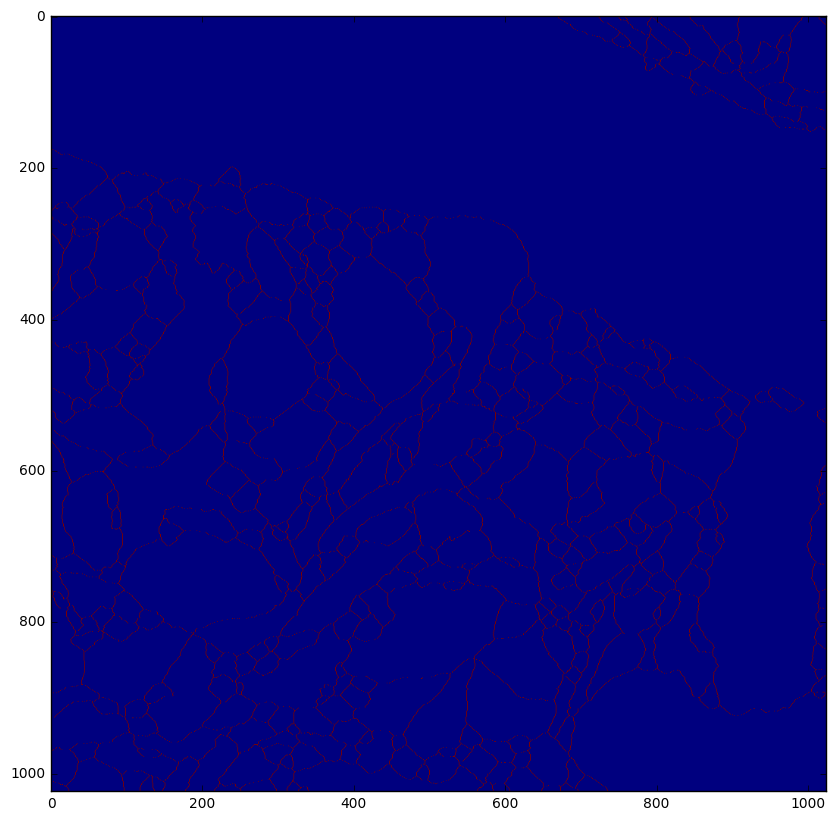

In [67]:
b_rle = C.B2D.get_borders(ac3[0], window_size=[4,2])
borders = C.B2D.resolve_borders(b_rle)

C.Util.adj_fig_size(10,10)
imshow(borders)

In [2]:
import mahotas as mh
mask = np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]])
mh_borders = mh.labeled.borders(ac3[0], Bc=mask)
mh_borders[0:4, 668:672]
np.array_equal(mh_borders, C.B2D.get_only_borders(ac3[0]))
C.Util.get_size(C.LZMA.compress(mh_borders))

25940

[autoreload of compression failed: Traceback (most recent call last):
  File "/Users/Fritz/Virtualenvs/cs222/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name B2N
]


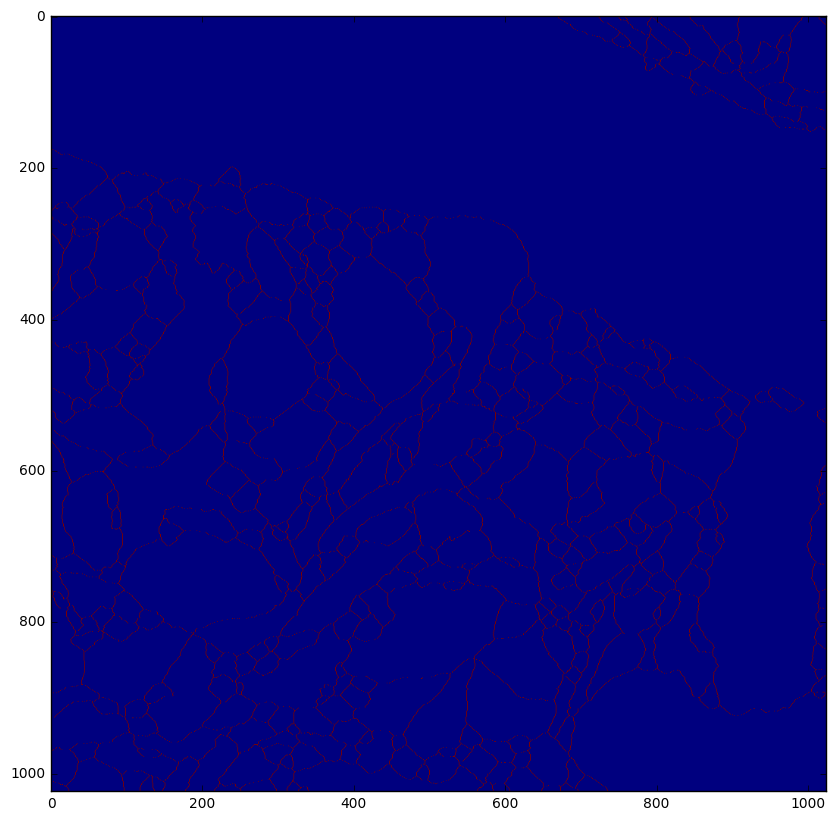

In [37]:
C.Util.adj_fig_size(10,10)
imshow(mh_borders)

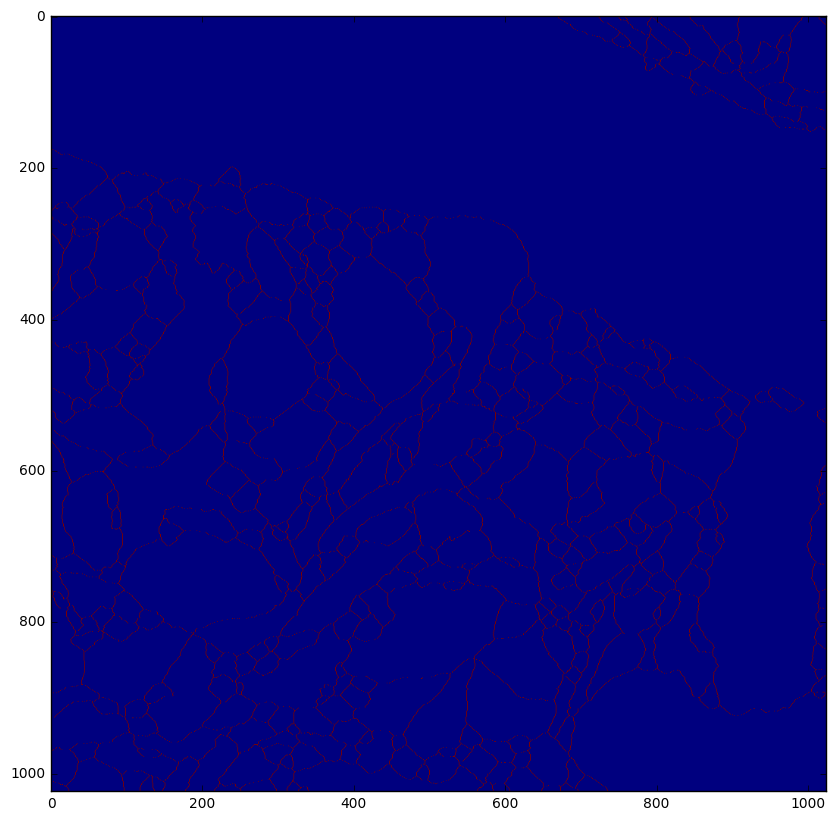

In [3]:
C.Util.adj_fig_size(10,10)
imshow(C.B2D.get_only_borders(ac3[0]))

In [8]:
print C.B2D.get_base_2_rep(215)
a = np.zeros(8, dtype=np.bool)
a[C.B2D.get_base_2_rep(215)] = True
a

[0, 1, 2, 4, 6, 7]


array([ True,  True,  True, False,  True, False,  True,  True], dtype=bool)

In [10]:
a = np.zeros(8, dtype=np.bool)
a.reshape(4,2)
a

array([False, False, False, False, False, False, False, False], dtype=bool)

In [18]:
C.B2D.get_base_2(215, 10)

AttributeError: type object 'B2D' has no attribute 'get_base_2'

In [36]:
a = np.array([[1,1,1,1,1,2,2,4,4],[1,1,2,2,2,3,3,3,3]])
b = np.zeros(a.shape, dtype=np.bool)
print a
print np.diff(a)
b[:, :-1] = np.diff(a)
print b
print np.where(b.flatten() == True)

[[1 1 1 1 1 2 2 4 4]
 [1 1 2 2 2 3 3 3 3]]
[[0 0 0 0 1 0 2 0]
 [0 1 0 0 1 0 0 0]]
[[False False False False  True False  True False False]
 [False  True False False  True False False False False]]
(array([ 4,  6, 10, 13]),)


In [61]:
np.array([1,2,3,4,5,6,7,8]).reshape(2, 4)

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])